<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/semana3/clase6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch 
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

#Clasificación multi-clase con redes neuronles artificiales

**Objetivo**: Encontrar una relación entre las carcterísticas fisicoquímicas de un vino y la calificación sensorial dada por un expeerto. 

## Contexto
Se presentan dos bases de datos relaciondas a las variantes rojo y blanco del portugués *Vinho Verde*. La base de datos se divide en dos: 

* La primera parte esta dada por las características fisicoquímicas del vino.
* La segunda parte esta dada por evaluación sensorial del vino (calificación).

Ningun razgo adicional como tipo de uva, marca, precio u otra característica a las ya mencionadas se encuentra presente.

Estos datos pueden ser usados para tareas clasificación o regresión. **El objetivo** debe ser encontrar una relación entre los atributos fisicoquímicos y la calificación dada.


Las clases de vinos presentes son : $3, 4, 5, 6, 7, 8$ y $9$. Se tienen $11$ razgos fisicoquímicos. Estas calificaciones no se encuentran balancedas, de hecho se pueden encontrar más vinos intermedios que vinos malos o buenos. No es seguro que todos los razgos fisicoquímicos sean relevantes para encontrar una relación con la calificación.

Fuente: https://www.kaggle.com/piyushagni5/white-wine-quality


In [2]:
url = 'https://raw.githubusercontent.com/deep-learning-with-pytorch/dlwpt-code/master/data/p1ch4/tabular-wine/winequality-white.csv'
data = pd.read_csv(url, delimiter=";")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
samples, n_features = data.to_numpy().shape
(samples, n_features)

(4898, 12)

In [5]:
clases = np.sort(data['quality'].unique())
clases

array([3, 4, 5, 6, 7, 8, 9])

## Preparación de base de datos

El conjunto de datos se puede caracterizar de la siguiente forma:

$$\mathcal{D} = \{(\mathbf x, y) \in \mathcal{X}\times C\}, $$

donde 
* $\mathcal{X} \subset \mathbb{R}^{4898 \times 11}:=$ representa el conjunto de razgos fisicoquímicos de las distintas muestras de vino.
* $C = \{3, 4, 5, 6, 7, 8, 9\}$ (representa el conjunto de calificación sensorial asociada).

## Análisis exploratorio de los datos

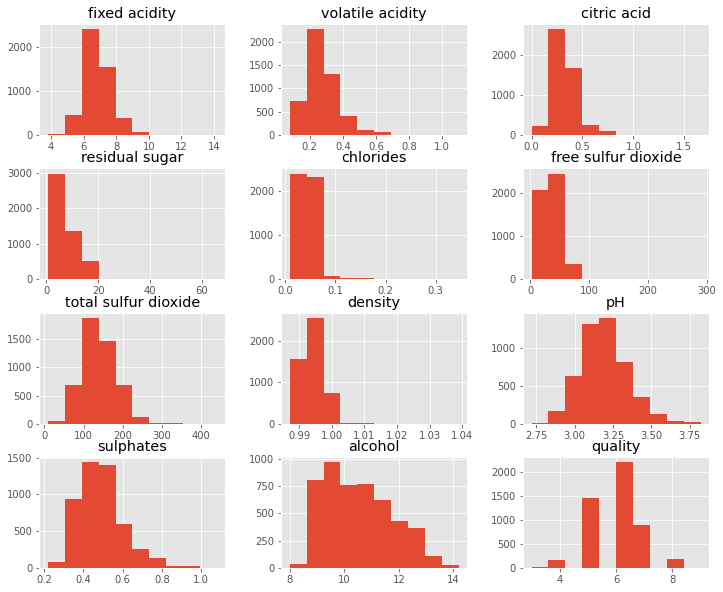

In [6]:
%matplotlib inline
data.hist(figsize=[12,10])
plt.show()

Dividimos el *dataframe* `data` en `training_data` ($\% 90$) y `test_data` ($\%10$), 

$$\mathcal{X} = \mathcal{X}_{train} \cup \mathcal{X}_{test}$$
$$C = C_{train} \cup C_{test}$$

In [7]:
msk = np.random.rand(len(data)) < 0.9
training_data = data[msk]
test_data = data[~msk]

### Media y desviación estándar de los datos de entrenamiento

In [8]:
X_train = training_data.drop('quality', axis=1)
mean_data = X_train.mean(axis=0)
mean_data

fixed acidity             6.854283
volatile acidity          0.278863
citric acid               0.334091
residual sugar            6.438112
chlorides                 0.045901
free sulfur dioxide      35.308797
total sulfur dioxide    138.641190
density                   0.994068
pH                        3.188102
sulphates                 0.490516
alcohol                  10.502135
dtype: float64

In [9]:
std_data = X_train.std(axis=0)
std_data

fixed acidity            0.829476
volatile acidity         0.101990
citric acid              0.120736
residual sugar           5.110846
chlorides                0.021972
free sulfur dioxide     16.628626
total sulfur dioxide    42.436365
density                  0.003017
pH                       0.151363
sulphates                0.115016
alcohol                  1.226483
dtype: float64

## Dataset

In [10]:
from torch.utils.data import Dataset

class DataframeDataset(Dataset):

  def __init__(self, data, y_name, transform=None, target_transform=None):
    '''
      data: pandas.DataFrame
    '''
    #self.data = torch.from_numpy(data.to_numpy()).to(dtype=torch.float32)
    self.Y = torch.tensor(data[y_name].to_numpy(), dtype=torch.long)
    aux = data.drop(y_name, axis=1).to_numpy()
    self.X = torch.from_numpy(aux).to(dtype=torch.float32)
    self.transform = transform
    self.target_transform = target_transform 

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)
    return x, y

### Transformaciones

Como vimos en el análisis exploratorio de los datos, los razgos tienen distintos ordenes de magnitud lo cual vuelve complicada la optimización de la red neuronal, pues tienen más peso los parámetros que acompañanan a los valores de mayor magnitud. Para facilitar la optimización cada uno de los razgos de cada muestra del conjunto de datos $\mathbf x \in {R}^{11}$ deben ser estandarizados, es decir, se les aplicara la siguiente transformación: 

$$x_j = \frac{x_j - \hat \mu_j}{\hat \sigma_j} \quad \forall j \in \{1, 2, \cdots, 11\}$$

**Nota:** Se deberán de usar las $\hat \mu_j$ y $\hat \sigma_j$ de los datos de entrenamiento y no del total de conjunto de datos.


Para efectos prácticos, las etiquetas $y \in C$ también deberán de ser tranformas de la siguiente manera: 
$$y = y - 3$$
de tal forma que 
$$C = \{0, 1, 2, 3, 4, 5, 6\}.$$

#### *One-hot encoding*

Se refiere a la codificación de clases en grupos de *bits*, donde el $j$-ésimo *bit* de un grupo esta prendido (tiene valor $1$) si el grupo esta asociado a la clase $j$ y el resto de *bits* estan apagados (tienen valor 0).

Esta técnica es ampliamente usada en los problemas de clasificación. La salida del modelo debe ser la densidad discreta de probabilidad, los valores de cada entrada representan la probailidad de pertenecia a cada una de las clases.
\begin{align*}
y_{one-hot} &= [0,\cdots, 0, \underbrace{1}_{j}, 0, \cdots, 0] \quad \text{(codificación de clase)} \\
\hat y &= [p_0, \cdots, p_{j-1}, p_{j}, p_{j+1}, \cdots, p_{m}] \quad \text{(salida del modelo)} \\
\text{donde }& \sum_{j=0}^{m}p_{j} = 1 
\end{align*}

En Pytorch, no es necesario usar la técnica *one-hot encoding*, pues ya estan implementados dentro de la función objetivo por lo tanto en este problema no haremos uso de esta técnica y conservaremos la representación como elemento del conjunto de clases para cada una de las etiquetas.




In [11]:
tx = lambda x: (x - torch.tensor(mean_data, dtype=torch.float32))/torch.tensor(std_data, dtype=torch.float32)
ty = lambda y: y - torch.tensor(3, dtype=torch.long)

In [12]:
train_dataset = DataframeDataset(training_data, y_name='quality', transform=tx, target_transform=ty)
test_dataset = DataframeDataset(test_data, y_name='quality', transform=tx, target_transform=ty)

### Validación

* datos de validación 10 \%.
* datos de prueba 10 \%.


In [13]:
evens = list(range(0, len(test_dataset), 2))
odds = list(range(1, len(test_dataset), 2))
val_dataset = torch.utils.data.Subset(test_dataset, evens)
test_dataset = torch.utils.data.Subset(test_dataset, odds)

In [14]:
n_train = len(train_dataset)
n_train

3899

In [15]:
n_val = len(val_dataset)
n_val

500

In [16]:
n_test = len(test_dataset)
n_test

499

## DataLoader

$$\mathcal{X}_{train} = X_{(1)} \cup X_{(2)} \cup \cdots \cup X_{(n_{batch})}$$

Donde $n_{batch}$ es el número de particiones que se hizo sobre el conjunto de datos de entrenamiento original.

In [17]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [18]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 11])
Labels batch shape: torch.Size([64])


## Softmax 
La función softmax se puede entender como la función de densidad de una variable aleatoria discreta $y$.
$$\mathbb{P}[y=i|\mathbf{x}] = \text{softmax}(\mathbf{x}) =\frac{e^{x_i}}{\sum_{j=1}^{k}e^{x_j}}$$

$$\mathbf{x} = [x_1, x_2, \cdots, x_{k}]$$
Es una función muy útil para la interpretación de valores para clasificación multiclase, esta función esta dada por

In [19]:
softmax = torch.nn.Softmax(dim=1)
x = torch.rand(1, 3)
y = softmax(x)
print(x)
print(y)
print(torch.sum(y, dim=1))

tensor([[0.2404, 0.2487, 0.8014]])
tensor([[0.2659, 0.2681, 0.4660]])
tensor([1.0000])


## Declaración de una red neuronal en Pytorch

* $k :=$ tamaño de mini-batch, *batch size* (64 casi todo el tiempo).
* $n :=$ numéro de razgos (11).
* $c = \#C$ (7)

Sea $f_a( \cdot |\theta): \mathbb{R}^{k \times n}\rightarrow [0,1]^{k \times c}$ con $a = \langle [n, 64, 64, c], \{\text{relu}, \text{relu}, \text{softmax}\}\rangle$ la red neuronal que usaremos para la tarea de clasificación. 

In [20]:
n_features = n_features -1 
n_clases = len(clases)
N = [64, 64]

In [21]:
from collections import OrderedDict
from torch import nn

# define model architecture
model = nn.Sequential(OrderedDict([
    ('z1', nn.Linear(n_features, 64)),
    ('h1', nn.ReLU()),
    ('z2', nn.Linear(64, 64)),
    ('h2', nn.ReLU()),
    ('z3', nn.Linear(64, n_clases)),
    #nn.Sigmoid()
]))

In [22]:
x = torch.randn(1, n_features) 

In [23]:
# instantiate the model
model(x)

tensor([[-0.0220, -0.0979, -0.1018,  0.0916, -0.0958, -0.0114, -0.1615]],
       grad_fn=<AddmmBackward>)

In [24]:
# print model architecture
print(model)

Sequential(
  (z1): Linear(in_features=11, out_features=64, bias=True)
  (h1): ReLU()
  (z2): Linear(in_features=64, out_features=64, bias=True)
  (h2): ReLU()
  (z3): Linear(in_features=64, out_features=7, bias=True)
)


Notemos que no estamos declarando por completo la red neuronal con la arquitectura que establecimos al inicio, pues le falta la función de activación softmax en la capa de salida. En este caso estamos declarando una red neural con arquitectura $a'=\langle [n, 64, 64, c], \{\text{ReLu}, \text{ReLu}, \text{Linear}\}\rangle$ y función $g_{a'}(\cdot | \theta): \mathbb{R}^{k \times n} \rightarrow \mathbb{R}^{k\times c}$, por lo que 
$$f_a(\cdot | \theta)=\text{softmax}\circ g_{a'}(\cdot |\theta)$$

Veremos que esta red será bastante útil para nuestra tarea.

## Visualización gráfica de la arquitectura  (`torchviz`)

In [25]:
!pip3 install torchviz
from torchviz import make_dot

yhat = model(x)
make_dot(yhat, params=dict(list(model.named_parameters()))).render("My network", format="png")

'My network.png'

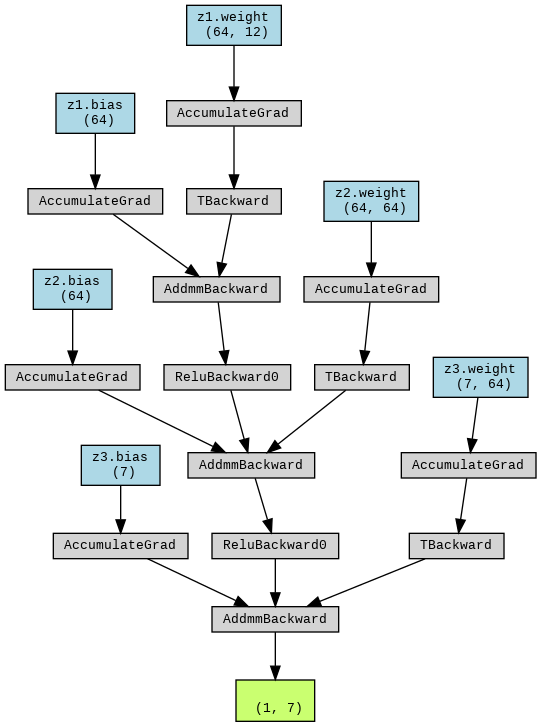

## Planteamiento del problema

$$\min_{\theta \in \mathbb{R}^{P([11, 64, 64, 7])}}CEL\left(\theta; Y_{(b)}, \hat{Y}_{(b)}\right) \qquad \forall b \in \{1, \cdots, n_{batch}\}$$

$$\hat{Y}_{(b)} = g_a\left(X_{(b)} |\theta\right)\quad Y_{(b)} \subset C.$$


### Categorical Cross-Entropy Loss

Una función usada para la clasificación multiclase. Suponiendo que cada $\mathbf z$ sigue una distribución multinomial de tamaño $N$, la función de costos nos dirá que tan distintos son ambos resultados

$$CEL\left(C, Z\right) = \frac{1}{N}\sum_{z, c\in Z \times C}\text{loss}(z, c)$$

$$\text{loss}(\mathbf{z}, \text{class}) = - \log\left(\frac{\exp(\mathbf{z}[\text{class}])}{\sum_{j} \exp(\mathbf{z}[j])}\right)\quad \mathbf{z}[j] = z_j \quad j \in \{1, \cdots, m\}$$

$$ Z \in \mathbb{R}^{k \times m} \quad C=\{c_1, c_2, \cdots, c_m\} \quad (m\text{ clases)}$$

In [26]:
ce_loss = nn.CrossEntropyLoss()
yhat = torch.rand(3, 5, requires_grad = True)
y = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(yhat, y)
print(loss)

tensor(1.6059, grad_fn=<NllLossBackward>)


In [27]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

## Entrenamiento

Usaremos la barra de progeso proporcionda por la biblioteca `tqdm`. A continuación se muestra un ejemplo.

In [28]:
from tqdm import tqdm

outer = tqdm(total=3, desc='Epoch', position=0)
for ii in range(3):
    inner = tqdm(total=5, desc='Batch', position=1)
    for jj in range(2):
        #do your training
        inner.update(1)
    outer.update(1)

Batch:  40%|████      | 2/5 [00:00<00:00, 429.22it/s]

Batch:  40%|████      | 2/5 [00:00<00:00, 313.99it/s]



Paso de aprendizaje por época o *epoch*.

In [29]:
import torch.nn.functional as F

def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

Ciclo de aprendizaje.

In [30]:
import time

EPOCHS = 200
train_time = 0

epoch_loss = []
epoch_acc = []

val_loss = []
val_acc = []

In [31]:
for epoch in range(EPOCHS):
  start_time = time.time()
  with tqdm(total=n_train, position=0) as pbar_train:
    pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - train')
    pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
    loss_train, acc_train = fit(model, train_dataloader, optimizer, criterion, pbar_train)
    train_time +=  time.time() - start_time
  with tqdm(total=n_val, position=0) as pbar_val:
    pbar_val.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - val')
    pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
    loss_val, acc_val = fit(model, val_dataloader, optimizer, criterion, pbar_val, train=False)

  epoch_loss.append(loss_train)
  epoch_acc.append(acc_train)

  val_loss.append(loss_val)
  val_acc.append(acc_val)

print("\n --- %s seconds ---", train_time)

Epoch 200/200 - validation: 100%|██████████| 500/500 [00:00<00:00, 4135.85it/s, acc=0.6140, avg_loss=1.0509]


 --- %s seconds --- 161.11698031425476


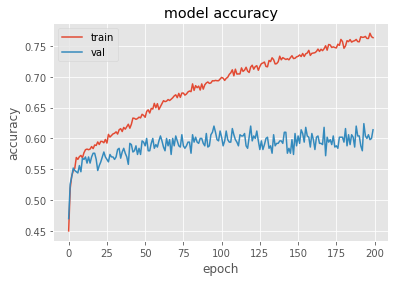

In [32]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

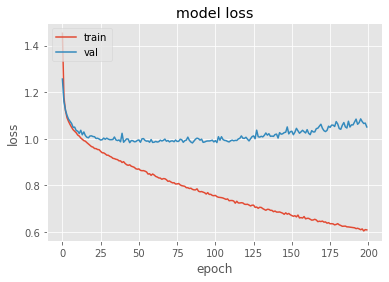

In [33]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Prueba del modelo

In [34]:
running_loss = 0.0
correct = 0
total = 0
model.eval()
for i, data in enumerate(test_dataloader, 0):
    X, Y = data        
    pred = model(X)
    loss = criterion(pred, Y)
    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
print('accuracy: {}, loss: {}'.format(acc, avg_loss))

accuracy: 0.5891783567134269, loss: 1.0344936666914653


## Ejercicios (opcionales)

1. Realiza el entrenamiento sin normalizar los datos de entrenamiento ¿Qué puedes observar sobre los valores `loss` y `acc` con respecto al anterior entrenamiento?

2. Modifica la arquitectura de la red neuroanl (# de capas, # de neuronas por capa, funciones de activación) ¿Puedes encontrar alguna combinación que mejoré el entrenamiento?

3. Realiza el entrenamiento usando `batch_size`=1 (*stochastic*) y usando `batch_size`= `n_train` (*batch*) ¿Qué comparación puedes hacer con respecto al entrenamiento usando *mini-batch*?

4. Modifica la clase `DataframeDataset` de tal forma que permita seleccionar ciertos razgos fisicoquímicos y haz las modificaciones pertinentes que permitan entrenar una red neuronal que pueda recibir dichos razgos fisicoquímicos ¿Mejora el entrenamiento si sólo se selecciona ciertos razgos?

Entrega: Viernes 8 de octubre 11:59 pm.